<div style="text-align: right;">
    <b>Prof. Alexandro Garro Brito</b><br>
    Sistemas de controle - trimestre 2025-3<br>
    Programa de Pós-Graduação em Engenharia de Sistemas Eletrônicos / UFSC
</div>


<div style="text-align: center;">
    <h1>Controle de motor CC em espaço de estados</h1>
    <h3>Pedro Henrique Melo Araujo</h3>
</div>

## 1. Introdução

O presente estudo aborda a modelagem e o controle de um motor de corrente contínua via espaço de estados. Inicialmente, foi realizada a modelagem física e análise da resposta transitória do sistema em malha aberta. Em seguida, o modelo foi representado e discretizado em espaço de estados, validando-se critérios de controlabilidade e observabilidade. Por fim, foi proposto um controlador por realimentação de estados com ação integral e de um observador para estimativa das variáveis de estado. 

## 1. Análise do sistema

Nesta seção, analisa-se a dinâmica do sistema por meio da obtenção da função de transferência que relaciona a tensão de armadura à velocidade angular. Na sequência, simulou-se a resposta ao degrau para avaliar o comportamento transitório do modelo obtido.

### 1.1 Modelagem física

A modelagem física do motor resulta no sistema de equações apresentado a seguir. As variáveis do modelo estão descritas no Quadro 1, e os parâmetros obtidos constam na Tabela 1.

$$
\begin{cases}
V_t(t) = L_a \frac{d i_a(t)}{dt} + R_a i_a(t) + E_a(t) \\
E_a(t) = K_e \omega(t) \\
\omega(t) = \frac{d \theta(t)}{dt} \\
\tau_{ele}(t) - \tau_L(t) = J \frac{d \omega(t)}{dt} + b \omega(t) \\
\tau_{ele} = K_{\tau} i_a(t) \\
\tau_L(t) = J_L \frac{d \omega(t)}{dt} + b_L \omega(t)
\end{cases} \tag{1}
$$


<p style="text-align: center; font-size: 11px; font-weight: bold; margin-bottom: 10px; font-family: serif;">
Quadro 1 - Variáveis do sistema.
</p>

<div style="display: flex; justify-content: center;">
    <table style="width: 70%; border-collapse: collapse; font-family: sans-serif;">
        <thead>
            <tr style="border-bottom: 2px solid #333;">
                <th style="text-align: left; padding: 8px;">Variável</th>
                <th style="text-align: left; padding: 8px;">Descrição</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$V_t(t)$</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">tensão terminal (V)</td>
            </tr>
            <tr style="background-color: #f9f9f9;">
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$E_a(t)$</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">força contra-eletromotriz (V)</td>
            </tr>
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$i_a(t)$</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">corrente de armadura (A)</td>
            </tr>
            <tr style="background-color: #f9f9f9;">
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$\tau_{ele}(t)$</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">torque da máquina ($N \cdot m$)</td>
            </tr>
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$\tau_L(t)$</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">torque de carga ($N \cdot m$)</td>
            </tr>
            <tr style="background-color: #f9f9f9;">
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$\omega(t)$</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">velocidade do eixo ($rad/s$)</td>
            </tr>
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$\theta(t)$</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">posição do eixo ($rad$)</td>
            </tr>
        </tbody>
    </table>
</div>

<p style="text-align: center; font-size: 11px; font-weight: bold; margin-bottom: 10px; font-family: serif;">
Tabela 1 - Parâmetros do sistema.
</p>

<div style="display: flex; justify-content: center;">
    <table style="width: 70%; border-collapse: collapse; font-family: sans-serif;">
        <thead>
            <tr style="border-bottom: 2px solid #333;">
                <th style="text-align: left; padding: 8px;">Descrição</th>
                <th style="text-align: left; padding: 8px;">Valor</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$L_a$ - indut. armadura</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">1,3 H</td>
            </tr>
            <tr style="background-color: #f9f9f9;">
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$R_a$ - resist. armadura</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">0,3 $\Omega$</td>
            </tr>
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$J$ - mom. inércia MCC</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">0,0013 $kg \cdot m^2$</td>
            </tr>
            <tr style="background-color: #f9f9f9;">
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$b$ - amort. rotacional MCC</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">0,00169 $N \cdot m \cdot s/rad$</td>
            </tr>
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$J_L$ - mom. inércia de carga</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">0,036056 $kg \cdot m^2$</td>
            </tr>
            <tr style="background-color: #f9f9f9;">
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$K_e$ - constante construtiva</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">0,0055678 $V \cdot s/rad$</td>
            </tr>
            <tr>
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$K_{\tau}$ - constante construtiva</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">0,23077 $N \cdot m/A$</td>
            </tr>
            <tr style="background-color: #f9f9f9;">
                <td style="padding: 6px; border-bottom: 1px solid #ddd; white-space: nowrap;">$b_L$ - amort. rotacional carga</td>
                <td style="padding: 6px; border-bottom: 1px solid #ddd;">0,0169 $N \cdot m \cdot s/rad$</td>
            </tr>
        </tbody>
    </table>
</div>

In [2]:

La = 1.3 # indutância de armadura (H)
Ra = 2.0 # resistência de armadura (ohms)
J = 0.0013 # momento de inércia (kg.m^2)
b = 0.00169 # amortecimento MCC (N.m.s/rad)
Jl = 0.036056 # momento de inércia da carga (kg.m^2)
Ke = 0.0055678 # constante construtiva (N.m/A)
Kt = 0.23077 # constante construtiva (N.m/A)
bl = 0.0169 # amortecimento rotacional da carga (N.m.s/rad) 

### 1.2 Diagrama de blocos do sistema

A Figura 2 apresenta o diagrama de blocos simplificado do sistema no domínio $s$. O diagrama destaca os sinais de entrada $R(s)$ e $Y(s)$, bem como as funções de transferência do controlador, $G_c(s)$, e da planta, $G(s)$. Ressalta-se que o projeto de $G_c(s)$ via função de transferência não compõe o escopo deste trabalho.


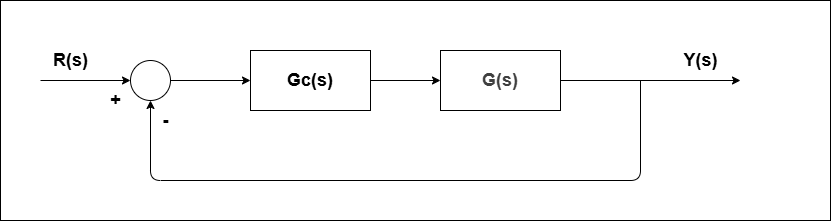

In [3]:
display_image_with_caption("figs/diagrama_de_blocos.png", 2, "Diagrama de blocos.")


### 1.3 Resposta ao degrau unitário

Para a análise preliminar do comportamento transitório, determinou-se a função de transferência que relaciona a tensão do estator à velocidade angular. Manipulando o sistema de equações 1 e aplicando a transformada de Laplace, obtém-se a função da Equação 2.

$$
G(s) = \frac{\Omega(s)}{V_i(s)} = \frac{K_t}{s^2[L_a(J + J_L)] + s[L_a(b + b_L) + R_a(J + J_L)] + [R_a(b + b_L) + K_eK_t]} \tag{2}
$$

Com base na função de transferência obtida, simulou-se a aplicação de um degrau unitário. A resposta transitória resultante é apresentada na Figura 2.

Num = [0.23077]   Den = [0.0485628, 0.07272980000000001, 0.025451881206]



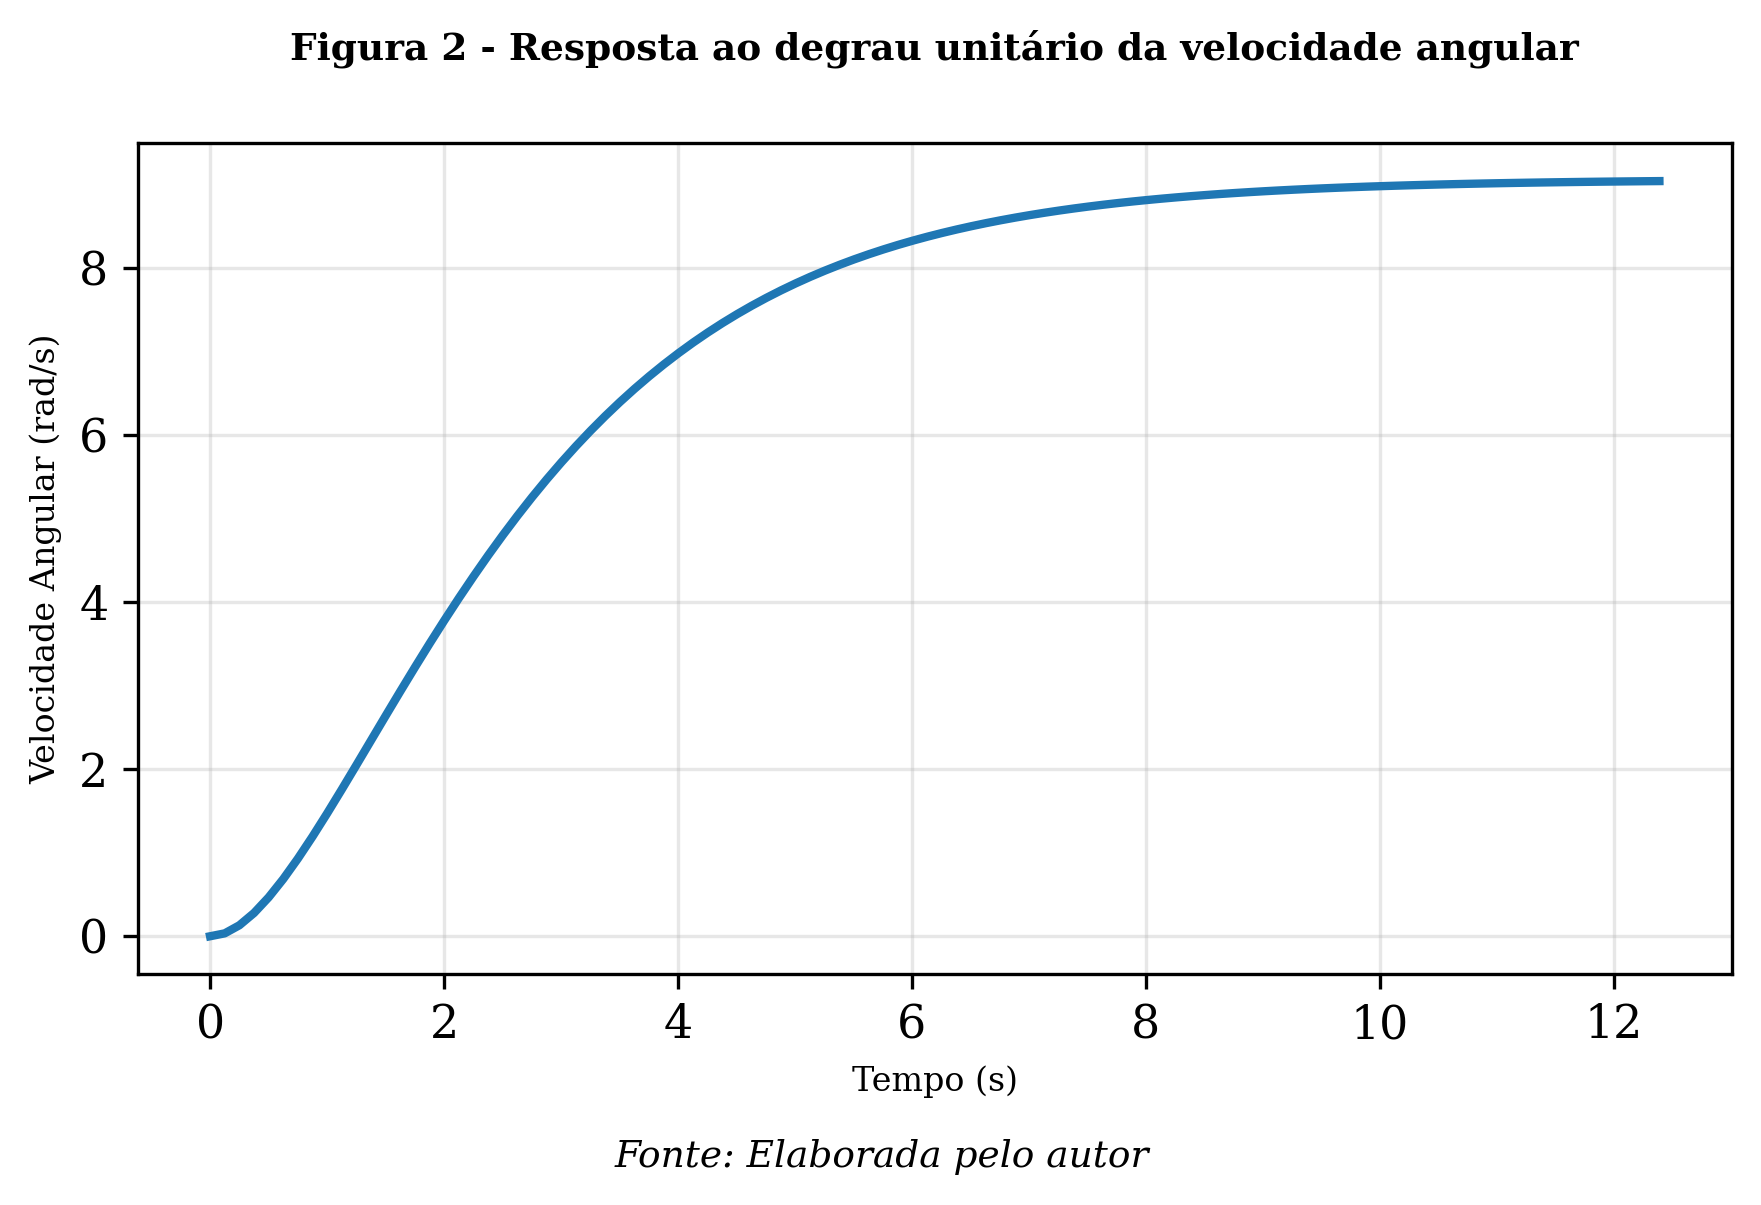

In [4]:
coef_num_1 = [Kt]
coef_denom_1 = [La*(J + Jl), La*(b + bl) + La*(J + Jl), La*(b + bl) + Ke*Kt]
print(f"Num = {coef_num_1}   Den = {coef_denom_1}")
G_1 = ct.tf(coef_num_1, coef_denom_1)
t, y =  ct.step_response(G_1)
print_graph(t, y, "Resposta ao degrau unitário da velocidade angular", "Tempo (s)", "Velocidade Angular (rad/s)", fig_number=2)


A análise da resposta ao degrau unitário evidencia um sistema de segunda ordem superamortecido ($\zeta \ge 1$), caracterizado pela ausência de sobressinal. Em regime permanente, a saída converge para 9 rad/s, definindo o ganho estático do sistema. O tempo de acomodação, situado entre 9 e 10 segundos, denota a dinâmica lenta da planta.

## 2. Representação em espaços de estados

Nesta seção, aborda-se a modelagem do motor de corrente contínua via espaço de estados, avaliando-se as propriedades de estabilidade, controlabilidade e observabilidade do sistema. Adicionalmente, apresenta-se o projeto de um controlador por realimentação de estados com ação integral, em conjunto com um observador de estados.

### 2.1 Obtenção do sistema em espaços de estados

A obtenção do modelo em espaço de estados inicia-se pela definição das variáveis de estado. A análise das equações diferenciais do motor indica que o comportamento dinâmico é plenamente descrito pela evolução da corrente de armadura $i_a(t)$ e a velocidade angular com as variáveis de estado.

O sistema possui duas entradas: a tensão de armadura $V_t(t)$ (variável manipulada) e o torque de carga  $\tau_L(t)$ (distúrbio). A saída de interesse é a velocidade angular $\omega(t)$. Assim, rescrevendo as equações dinâmicas em função das variáveis de estados e das entradas, tem-se a Equação 4.

$$
\left\{
\begin{aligned}
\frac{di_a(t)}{dt} &= -(R_a/L_a)i_a(t) - (K_e/L_a)\omega(t) + (1/L_a)V_t \\
\frac{d\omega(t)}{dt} &= (K_T/J)i_a(t) - (b/J)\omega(t) - (1/J)\tau_L(t) \\
y(t) &= \omega(t)
\end{aligned}
\right. \tag{4}
$$

Reescrevendo essas equações na estrutura matricial indicada na Equação 5, obtém-se o modelo em espaço de estados do sistema, detalhado na Equação 6.

$$
\begin{cases}
\dot{\vec{x}}(t) = \mathbf{A}\vec{x}(t) + \mathbf{B}\vec{u}(t) \\
\vec{y}(t) = \mathbf{C}\vec{x}(t) + \mathbf{D}\vec{u}(t)
\end{cases} \tag{5}
$$

$$
\begin{cases}
\begin{bmatrix}
\frac{di_a(t)}{dt} \\
\\
\frac{d\omega(t)}{dt}
\end{bmatrix}
=
\begin{bmatrix}
-\frac{R_a}{L_a} & -\frac{K_e}{L_a} \\
\\
\frac{K_T}{J} & -\frac{b}{J}
\end{bmatrix}
\begin{bmatrix}
i_a(t) \\
\\
\omega(t)
\end{bmatrix}
+
\begin{bmatrix}
\frac{1}{L_a} & 0 \\
\\
0 & -\frac{1}{J}
\end{bmatrix}
\begin{bmatrix}
V_t(t) \\
\\
\tau_L(t)
\end{bmatrix}
\\
\\
y(t) =
\begin{bmatrix}
0 & 1
\end{bmatrix}
\begin{bmatrix}
i_a(t) \\
\\
\omega(t)
\end{bmatrix}
+
\begin{bmatrix}
0 & 0
\end{bmatrix}
\begin{bmatrix}
V_t(t) \\
\\
\tau_L(t)
\end{bmatrix}
\end{cases} \tag{6}
$$

### 2.2 Análise dos polos e zeros

Em seguida, serão analisados os polos e zeros do sistema representado em espaços de estados. Os polos do sistema são os autovalores da matriz A, tomando o caso contínuo podemos calcular os polos como mostrado na Equação 6.

Na sequência, analisam-se os polos e zeros do sistema representado em espaço de estados. Os polos correspondem aos autovalores da matriz $A$ das variáveis de estado. Para o caso contínuo, o seu cálculo é determinado pela relação apresentada na equação 7. 

$$
det(\nu \mathbf{I} - \mathbf{A}) = 0 \tag{7}
$$


In [5]:
A = np.array([
    [-Ra/La, -Ke/La],
    [Kt/J,     -b/J]])
B = np.array([
    [1/La, 0],
    [0, -1/J]])
C = np.array([[0, 1]])
D = np.array([[0, 0]])

sys_cont = ct.ss(A, B, C, D)
polos = ct.poles(sys_cont)
print(f"Polos do sistema: {polos}")


Polos do sistema: [-1.41923077+0.86375272j -1.41923077-0.86375272j]


A determinação dos zeros de transmissão do sistema é realizada por meio da resolução da Equação 8. 

$$
\mathbf{C} \cdot \text{adj}(\nu \mathbf{I} - \mathbf{A}) \cdot \mathbf{B} = 0 \tag{8}
$$

In [6]:
zeros = ct.zeros(sys_cont)
print(f"Zeros do sistema: {zeros}")

Zeros do sistema: []


Com base nos valores calculados, apresenta-se o mapa de polos e zeros do sistema, na Figura 3.


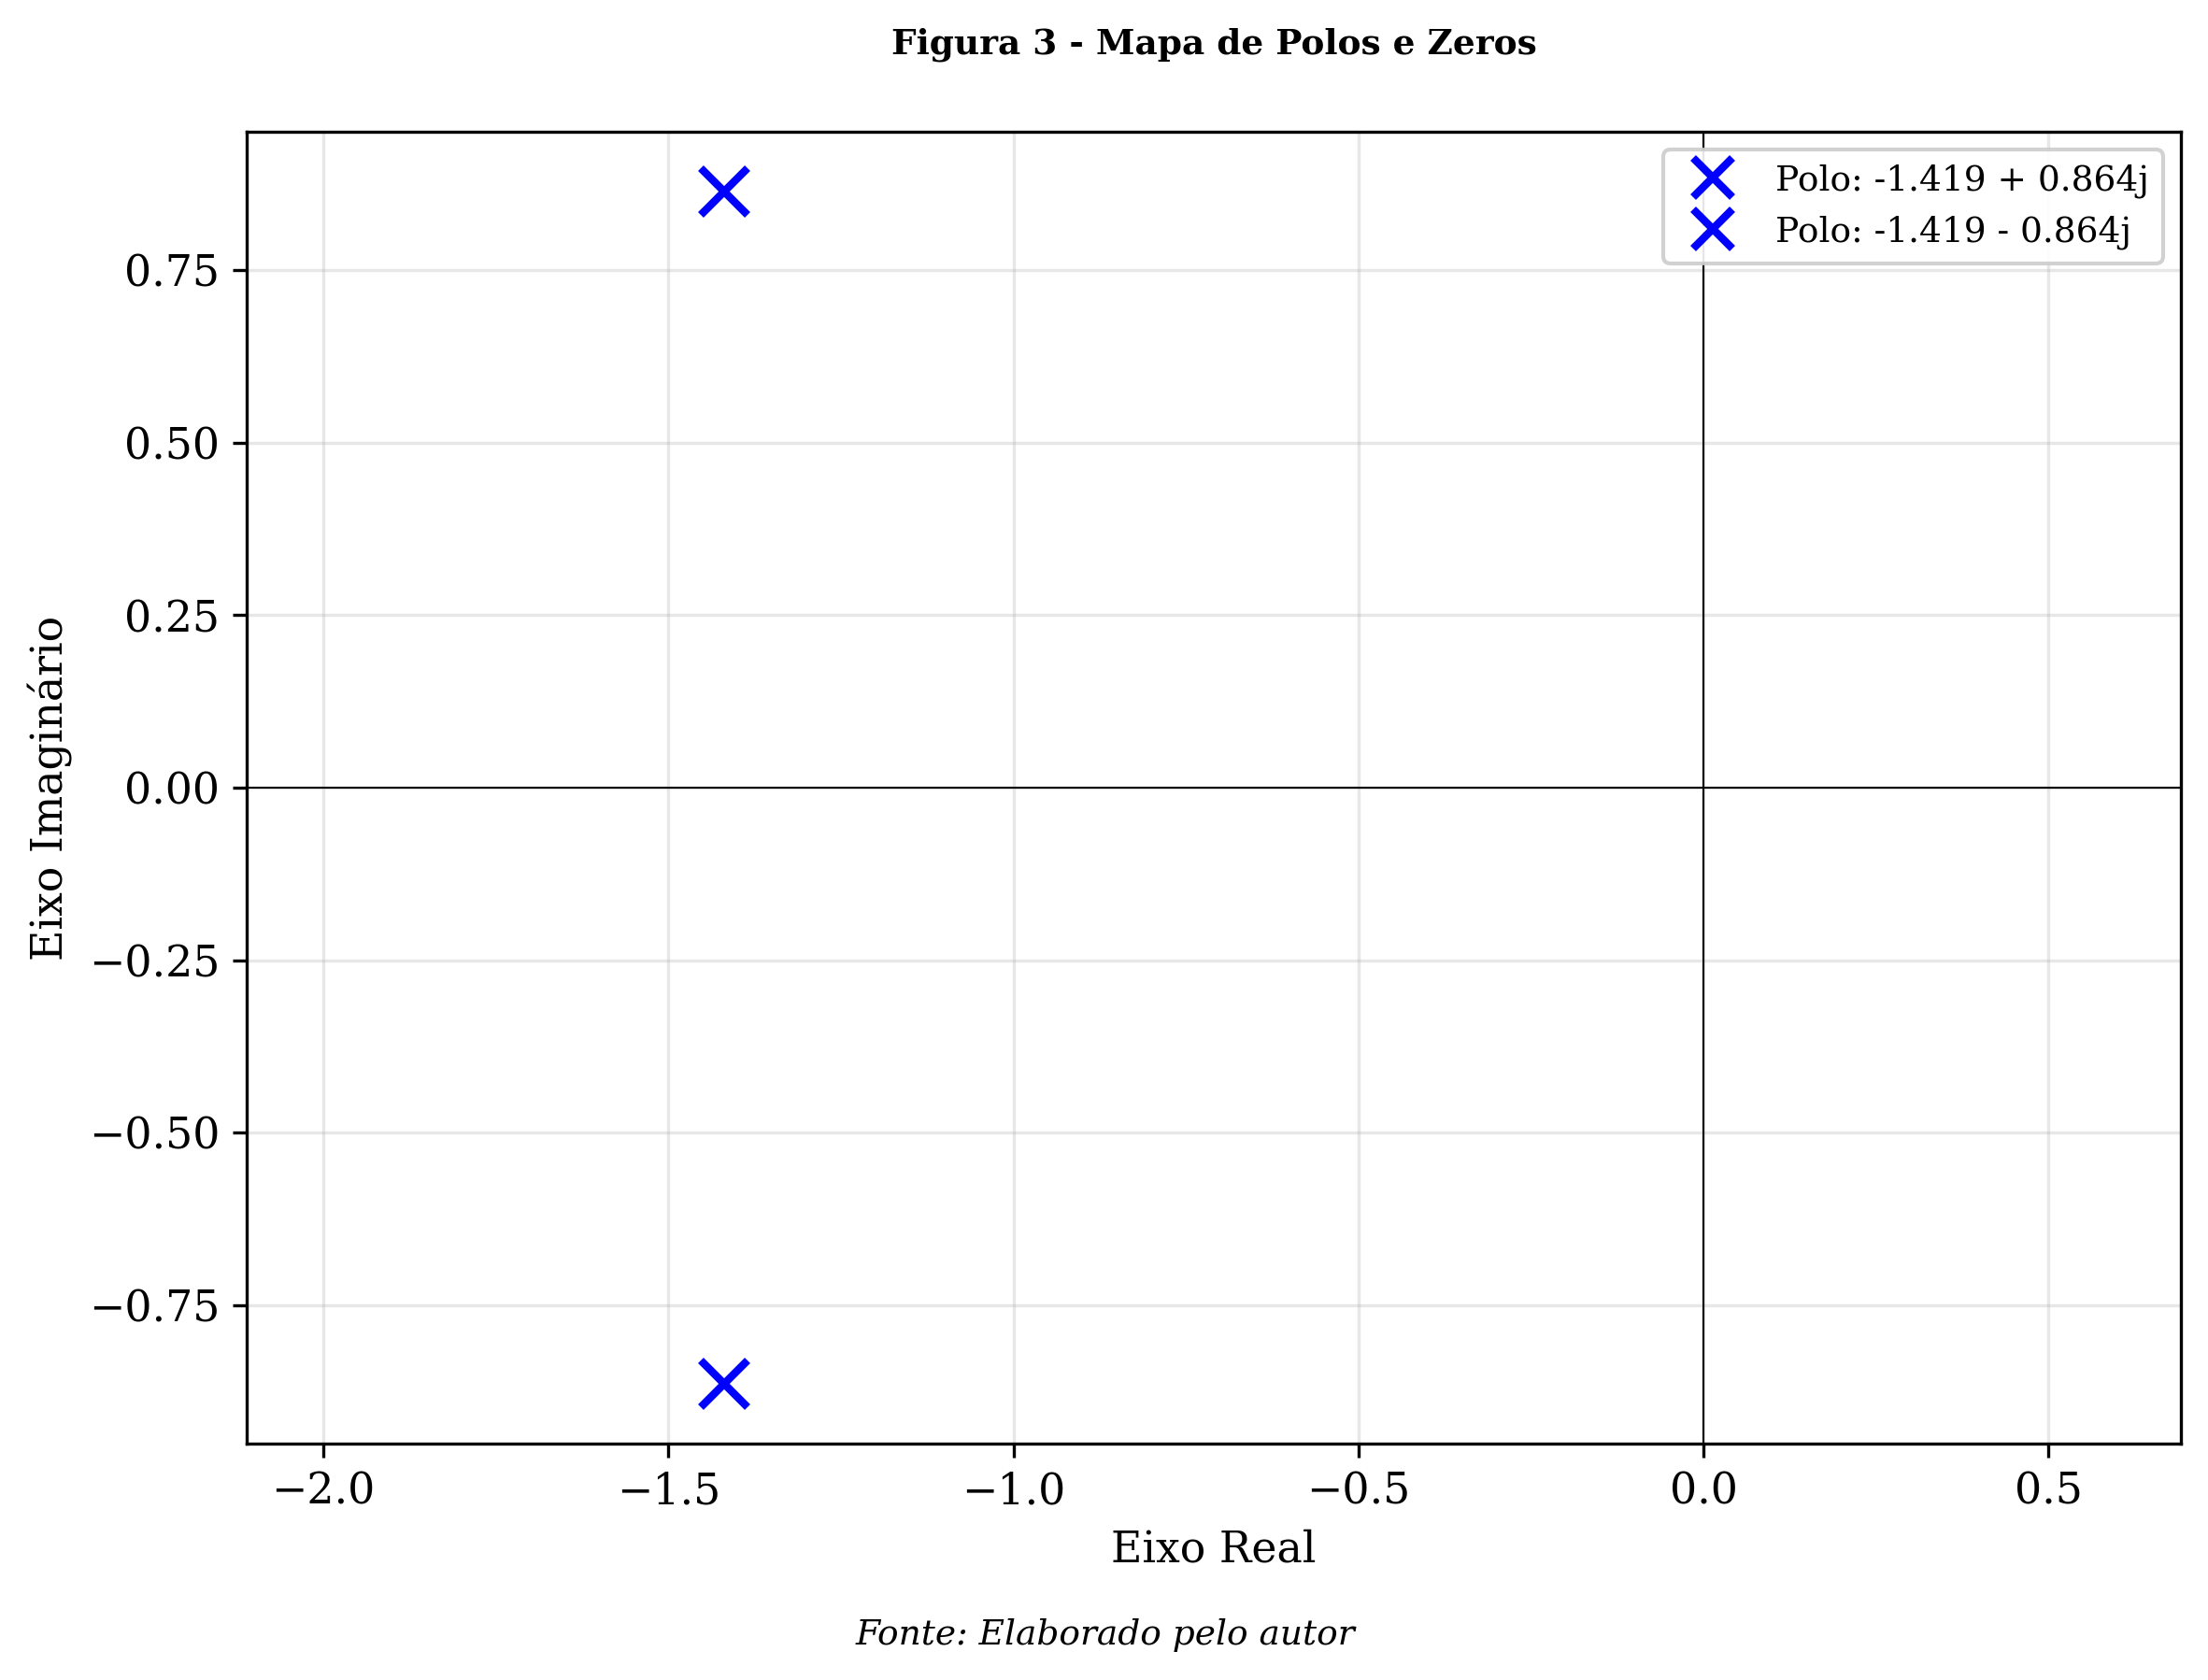

In [7]:
print_pzmap(sys_cont, fig_number=3)

A análise do mapa de polos e zeros revela a existência de um par de polos complexos conjugados em malha aberta, localizados em  $s \approx -1,42 \pm 0,86j$, e a ausência de zeros finitos. O sistema é considerado estável, dado que a parte real dos polos é estritamente negativa, o que os posiciona no semiplano complexo esquerdo. Adicionalmente, a natureza complexa dos polos caracteriza a dinâmica do sistema como subamortecida, indicando que a resposta ao degrau apresentará um comportamento oscilatório transitório antes da convergência para o regime permanente.

## 3. Discretização do sistema 

Para a discretização do modelo, aplicou-se o método de **Euler**. Ao substituir a aproximação da derivada (Equação 8) na definição de espaço de estados para sistemas contínuos, obtém-se o modelo discreto apresentado na Equação 9.

$$
\dot{x}(t) \approx \frac{x[k+1] - x[k]}{T_s} \tag{8}
$$

$$
\begin{cases}
\vec{x}[k+1] = \mathbf{A}_d\vec{x}[k] + \mathbf{B}_d\vec{u}[k] \\
\vec{y}[k] = \mathbf{C}_d\vec{x}[k] + \mathbf{D}_d\vec{u}[k]
\end{cases} \tag{9}
$$

Onde as matrizes discretizadas pelo método de Euler são definidas como:

- $\mathbf{A}_d = T_s \mathbf{A} + \mathbf{I}$
- $\mathbf{B}_d = T_s \mathbf{B}$
- $\mathbf{C}_d = \mathbf{C}$
- $\mathbf{D}_d = \mathbf{D}$

Logo, aplicando os parâmetros do motor, o sistema é representado pela Equação 10.

$$
\begin{cases}
\begin{bmatrix}
i_a[k+1] \\
\\
\omega[k+1]
\end{bmatrix}
=
\begin{bmatrix}
1 - \frac{T_s R_a}{L_a} & -\frac{T_s K_e}{L_a} \\
\\
\frac{T_s K_T}{J} & 1 - \frac{T_s b}{J}
\end{bmatrix}
\begin{bmatrix}
i_a[k] \\
\\
\omega[k]
\end{bmatrix}
+
\begin{bmatrix}
\frac{T_s}{L_a} & 0 \\
\\
0 & -\frac{T_s}{J}
\end{bmatrix}
\begin{bmatrix}
V_t[k] \\
\\
\tau_L[k]
\end{bmatrix}
\\
\\
y[k] =
\begin{bmatrix}
0 & 1
\end{bmatrix}
\begin{bmatrix}
i_a[k] \\
\\
\omega[k]
\end{bmatrix}
+
\begin{bmatrix}
0 & 0
\end{bmatrix}
\begin{bmatrix}
V_t[k] \\
\\
\tau_L[k]
\end{bmatrix}
\end{cases} \tag{10}
$$ 

Adotando um tempo de amostragem de $T_s = 5 \text{ ms}$ ($0,005 \text{ s}$), obtém-se:

In [8]:
# Sampling time
Ts = 0.005

sys_dis = sys_cont.sample(Ts, method="euler")
Ad = sys_dis.A
Bd = sys_dis.B
Dd = sys_dis.D
Cd = sys_dis.C

print(f"Matriz Ad discreta:\n {Ad}")
print(f"\nMatriz Bd discreta:\n {Bd}")
print(f"\nMatriz Cd discreta: {Dd}")
print(f"\nMatriz Dd discreta: {Cd}")



Matriz Ad discreta:
 [[ 9.92307692e-01 -2.14146154e-05]
 [ 8.87576923e-01  9.93500000e-01]]

Matriz Bd discreta:
 [[ 3.84615385e-03  0.00000000e+00]
 [ 0.00000000e+00 -3.84615385e+00]]

Matriz Cd discreta: [[0. 0.]]

Matriz Dd discreta: [[0. 1.]]


$$
\begin{aligned}
\mathbf{x}[k+1] &= 
\begin{bmatrix} 
9.9231 \times 10^{-1} & -2.1415 \times 10^{-5} \\ 
8.8758 \times 10^{-1} & 9.9350 \times 10^{-1} 
\end{bmatrix} \mathbf{x}[k] + 
\begin{bmatrix} 
3.8462 \times 10^{-3} & 0 \\ 
0 & -3.8462 
\end{bmatrix} \mathbf{u}[k] \\[1em]
\mathbf{y}[k] &= 
\begin{bmatrix} 
0 & 1 
\end{bmatrix} \mathbf{x}[k]
\end{aligned} \tag{11}
$$

Analisando a estabilidade do sistema obtido, calculam-se os autovalores da matriz dinâmica discretizada $\mathbf{A}_d$. Para um sistema discreto ser estável, as raízes da equação característica devem estar contidas no círculo unitário do plano complexo, ou seja, $|z_i| < 1$. A Figura 4 apresenta o resultado do cálculo da estabilidade do sistema discreto.


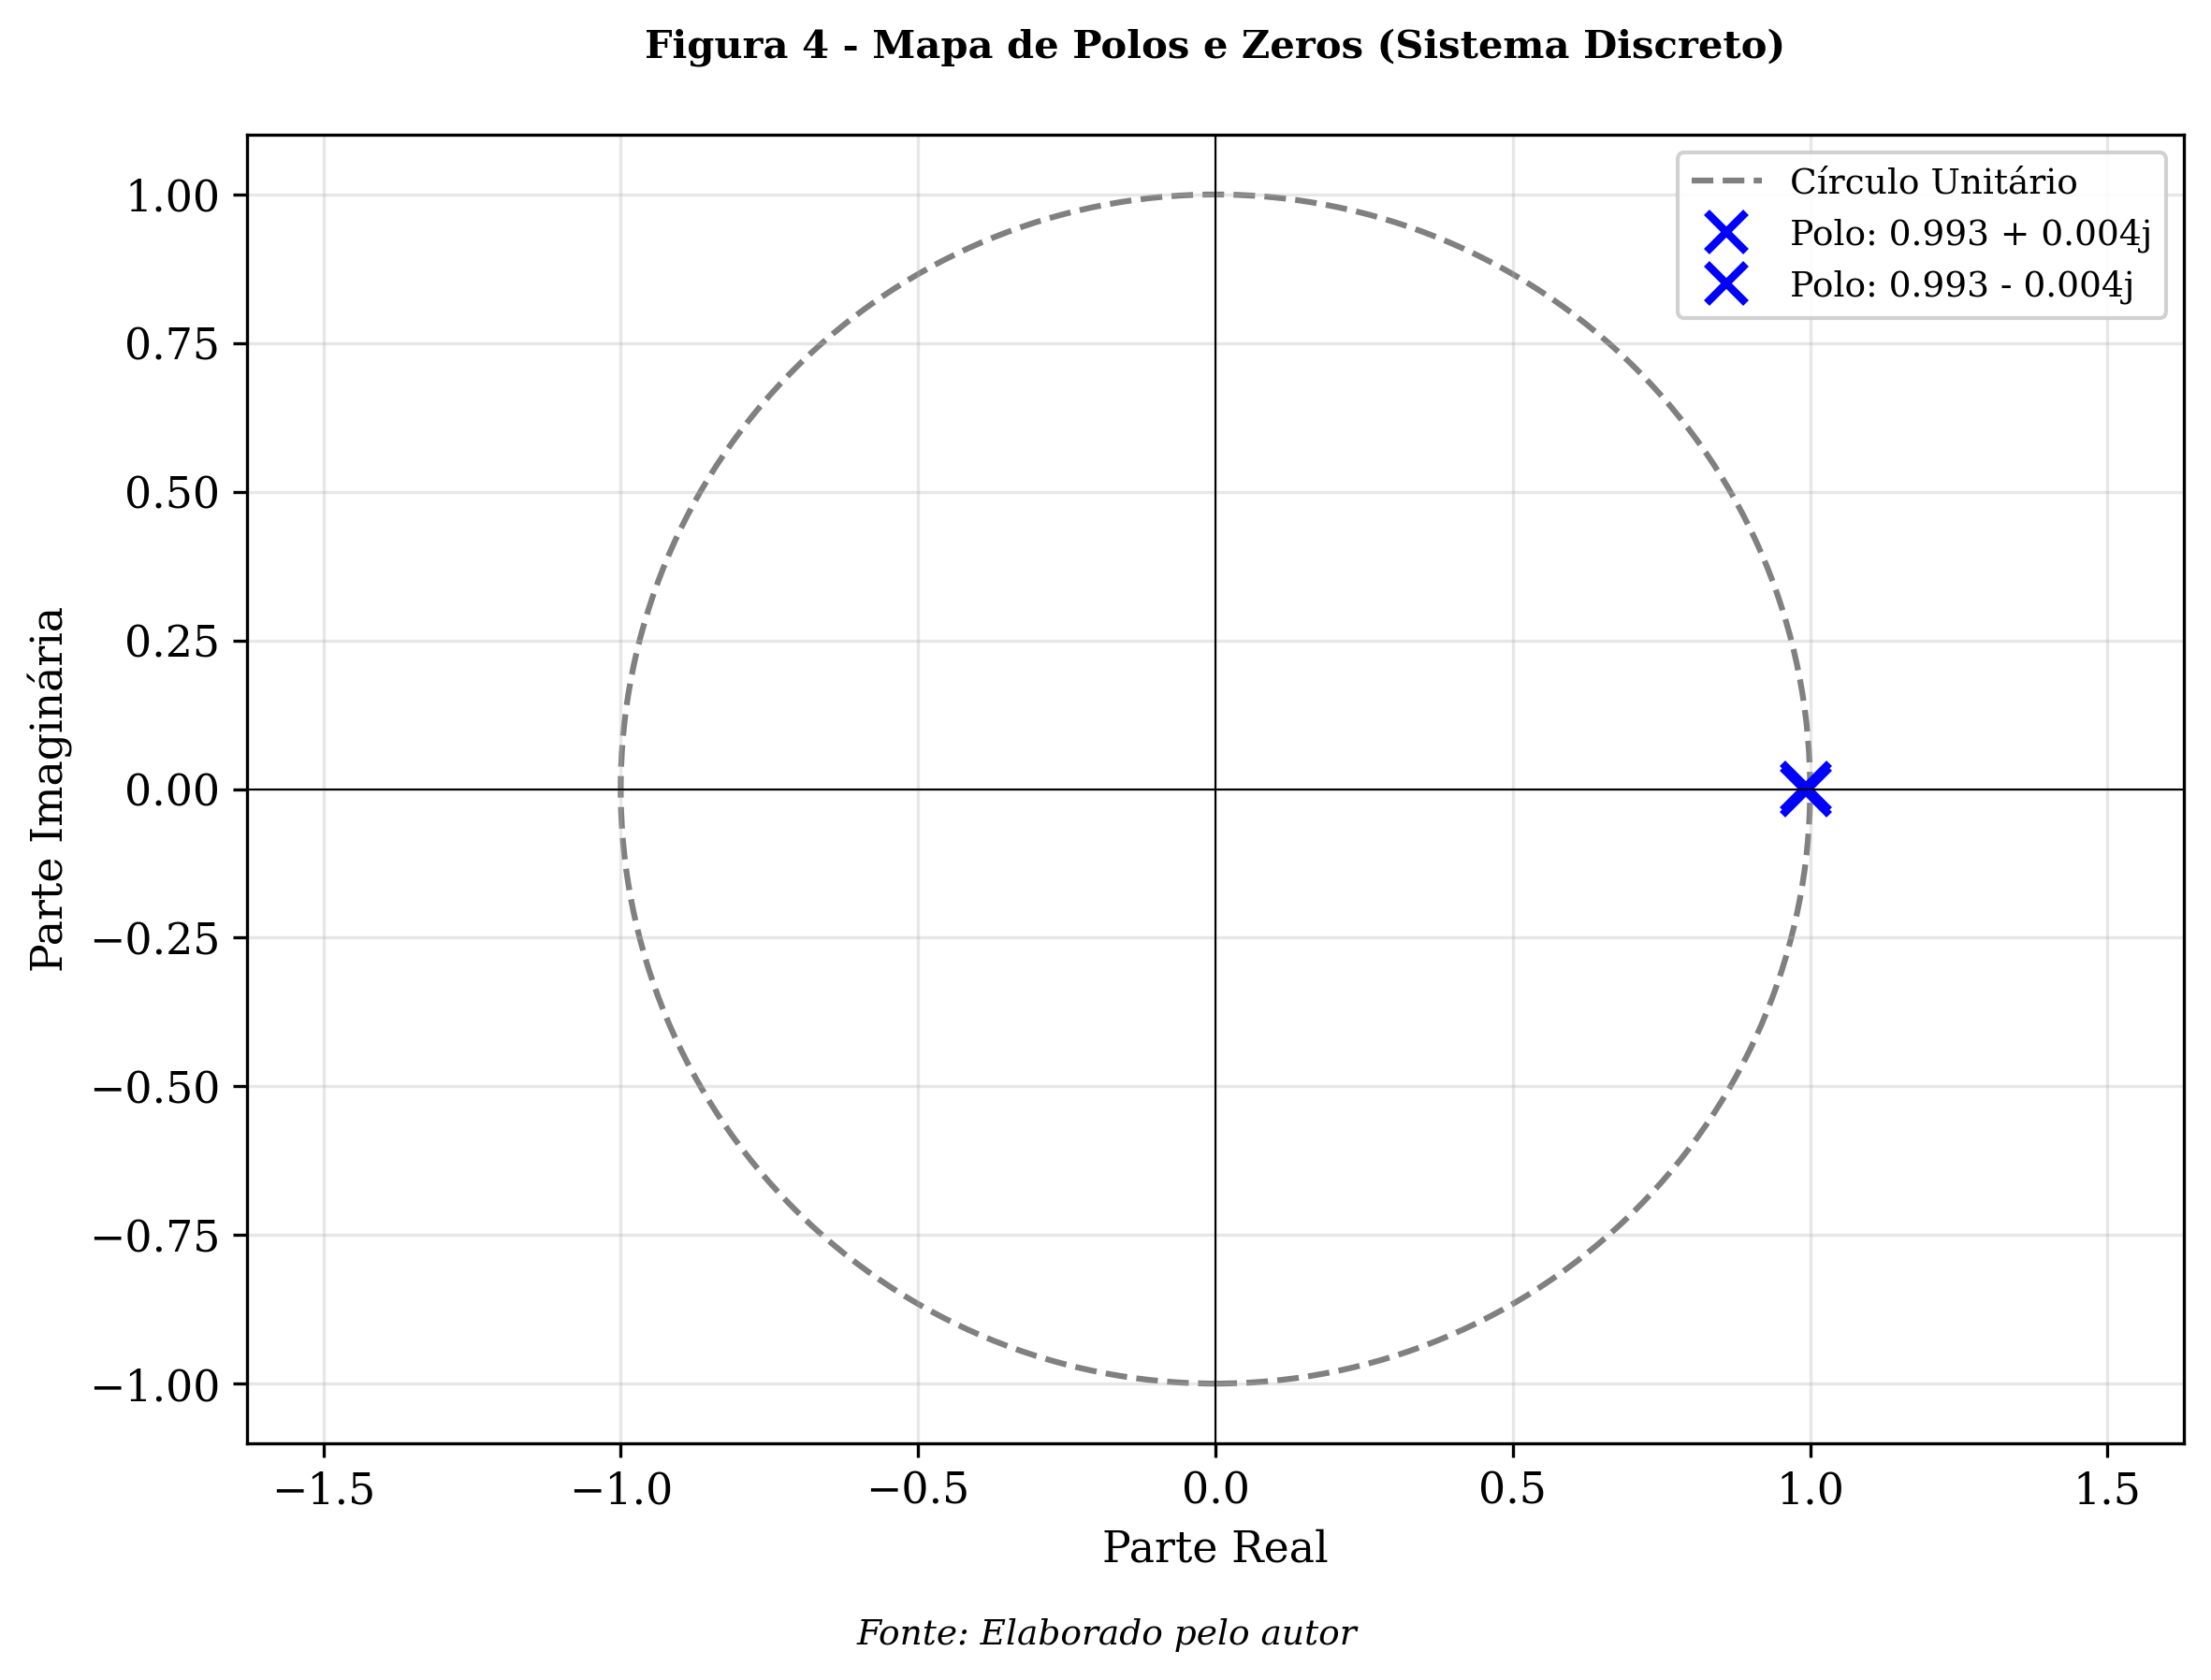

In [9]:
print_pzmap(sys_dis, 4)

Como $|z| < 1$, conclui-se que o sistema discretizado mantém a estabilidade do sistema contínuo original. A proximidade do módulo com a unidade é esperada devido ao pequeno tempo de amostragem, o que mapeia os polos próximos da origem do plano S para perto da fronteira de estabilidade do plano Z.

A validação da discretização é apresentada na comparação das respostas temporais ao degrau unitário da tensão (Figura 5).


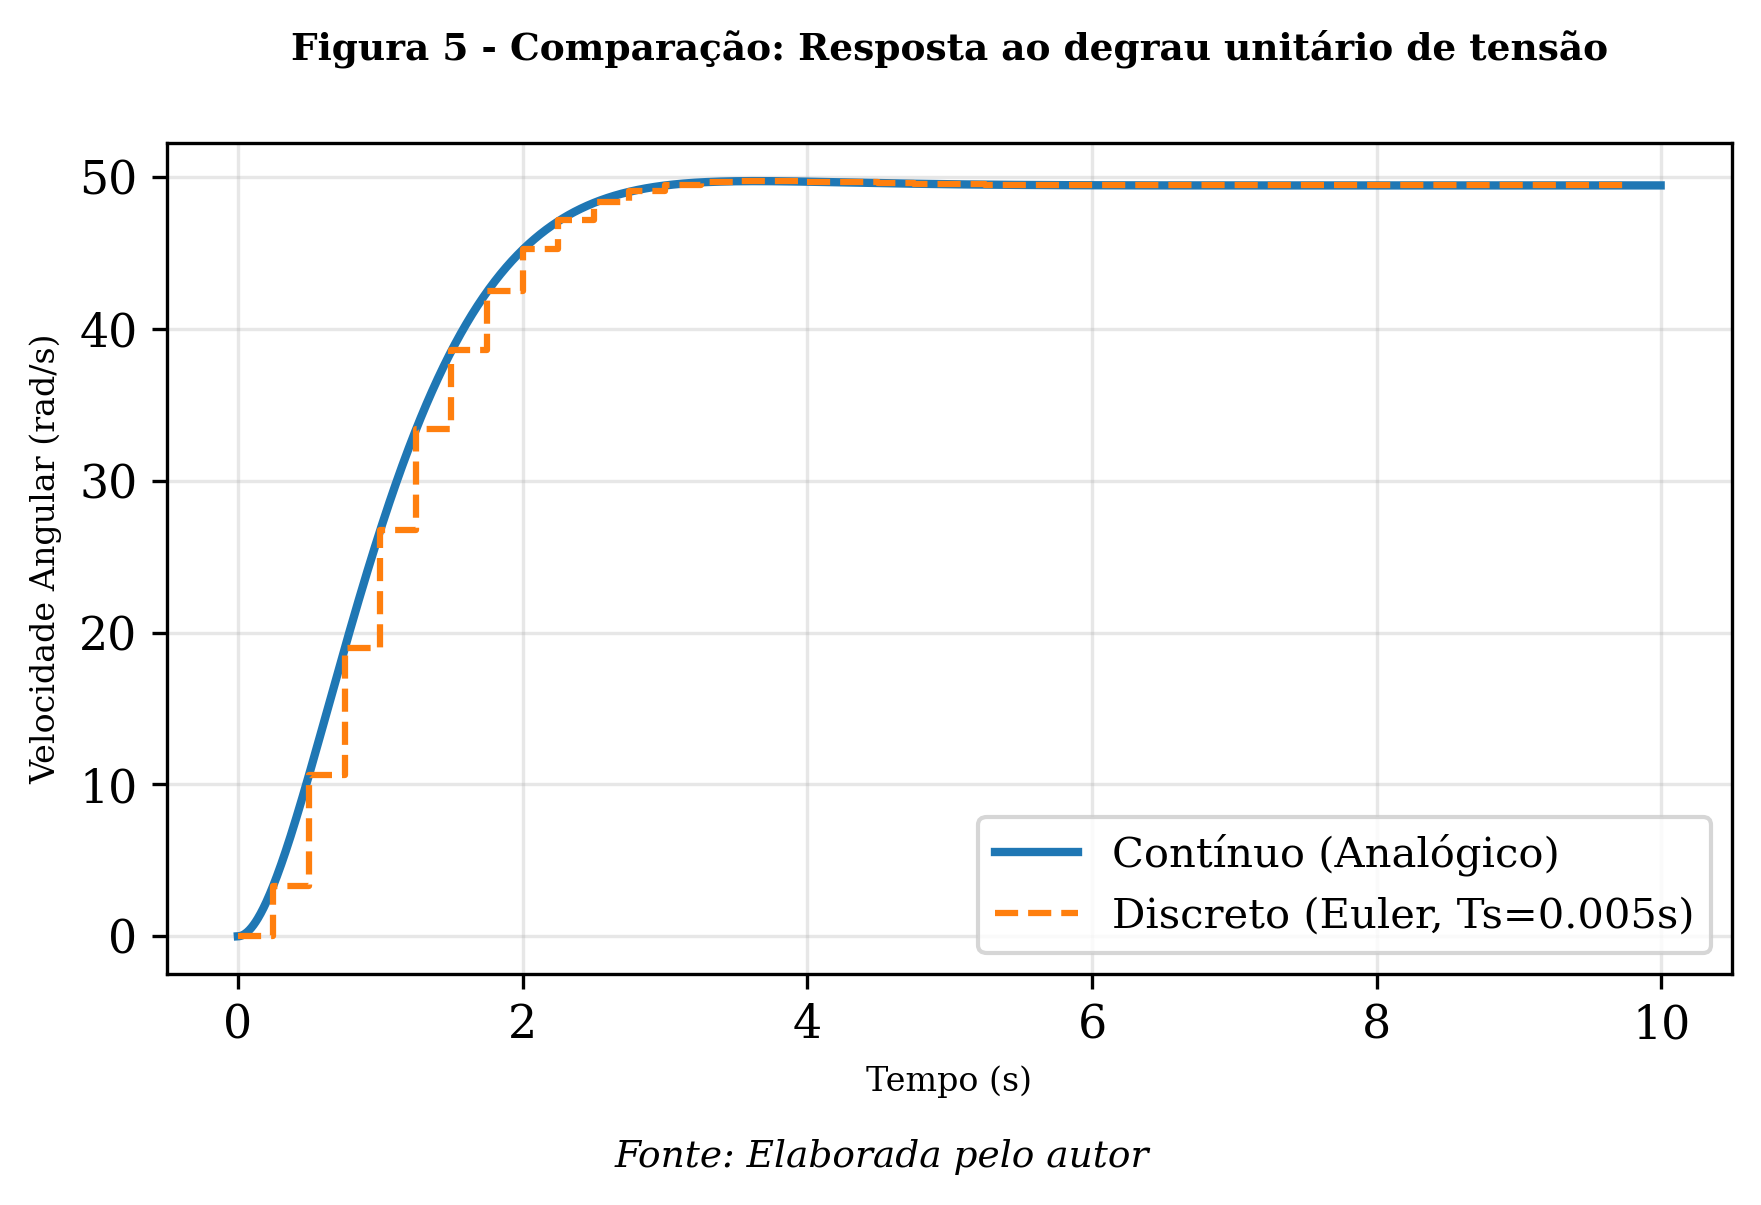

In [10]:
t_final = 10.0
t = np.arange(0, t_final, Ts)

U = np.zeros((2, len(t)))
U[0, :] = 1.0  

t_c, y_c = ct.forced_response(sys_cont, T=t, U=U)
t_d, y_d = ct.forced_response(sys_dis, T=t, U=U)

print_graph(t_c, y_c[0], 
           "Comparação: Resposta ao degrau unitário de tensão", 
           "Tempo (s)", 
           "Velocidade Angular (rad/s)", 
           fig_number=5,
           t2=t_d, 
           y2=y_d[0],
           label1="Contínuo (Analógico)",
           label2=f"Discreto (Euler, Ts={Ts}s)")



Observa-se uma aderência satisfatória entre a dinâmica do modelo contínuo e o modelo discretizado via método de Euler. O comportamento em "escada" da curva discreta reflete a natureza amostrada do sinal e o efeito de retenção, sem apresentar divergências numéricas ou instabilidade validando a escolha do tempo de amostragem ($T_s = 5\text{ ms}$).

## 4. Análise da controlabilidade e observabilidade

Com base no modelo discreto obtido na seção anterior (Equação 12), realiza-se a análise das propriedade estruturais de controlabilidade e observabilidade do sistema.

### 4.1 Controlabilidade

A controlabilidade determina se é possível transferir o vetor de estados, corrente $i_a$ e velocidade $\omega$, de uma condição inicial arbitrária para uma condição final desejada em um intervalo de tempo finito, utilizando um sinal de controle adequado. A condição necessária e suficiente para controlabilidade é que a matriz de controlabilidade  $\mathcal{C}$ possuo posto cheio, ou seja, igual ao número de estados do sistema $n$.

A matriz $\mathcal{C}$ é definida como: 

$$
\mathcal{C} = \left[ \mathbf{B}_d \quad \mathbf{A}_d \mathbf{B}_d \quad \dots \quad \mathbf{A}_d^{n-1} \mathbf{B}_d \right] \tag{12}
$$

No sistema em análise, a matriz de entrada $\mathbf{B}_d$ original possui duas colunas: a primeira referente à tensão de armadura $V_t$, que é a variável manipulada pelo controlador, e a segunda referente ao torque de carga $\tau_L$, que atua como um distúrbio não manipulável. Para fins de projeto de controlador, analisa-se a controlabilidade exclusivamente sob a ótica da entrada de controle $V_t$.

Considerando apenas a primeira coluna da matriz $\mathbf{B}_d$, referente à tensão de armadura $V_t$, obtém-se a matriz $\mathcal{C}$:

In [11]:
Bd_atuador = Bd[:, 0].reshape(-1, 1)                    # Usar apenas a coluna relacionada a Vt 
C = ct.ctrb(Ad, Bd_atuador)                             # Matriz de controlabilidade  
posto = np.linalg.matrix_rank(C)                        # Verificar o posto da matriz
num_states = Ad.shape[0]                                # Número de estados
print(f"Matriz de Controlabilidade (Atuador):\n{C}")
print("-" * 30)
print(f"Número de Estados (n): {num_states}")
print(f"Posto da Matriz: {posto}")

Matriz de Controlabilidade (Atuador):
[[0.00384615 0.00381657]
 [0.         0.00341376]]
------------------------------
Número de Estados (n): 2
Posto da Matriz: 2


$$
\mathcal{C} = 
\begin{bmatrix} 
3.8462 \times 10^{-3} & 3.8166 \times 10^{-3} \\ 
0 & 3.4138 \times 10^{-3} 
\end{bmatrix} \tag{13}
$$

Analisando o posto da matriz:

$$
\begin{cases} 
n = 2 \\
\text{posto}(\mathcal{C}) = 2
\end{cases}
\therefore \text{Sistema Controlável}
$$

Como a matriz a  $\mathcal{C}$ apresenta posto cheio, suas colunas são linearmente independentes, conclui-se que o sistema é completamente controlável através da tensão terminal. Isso garante a possibilidade de alocar arbitrariamente os polos de malha fechada.

### 4.2 Observabilidade

A observabilidade é a propriedade dual a controlabilidade e refere-se à capacidade de determinar o estado interno do sistema ($\mathbf{x}[k]$) a partir do conhecimento das entradas e das saídas medidas em um intervalo de tempo finito. 

A matriz de observabilidade $\mathcal{O}$ é dada por: 

$$
\mathcal{O} = 
\begin{bmatrix} 
\mathbf{C}_d \\ 
\mathbf{C}_d \mathbf{A}_d \\ 
\vdots \\ 
\mathbf{C}_d \mathbf{A}_d^{n-1} 
\end{bmatrix}   \tag{14}
$$

Considerando a matriz de saída $\mathbf{C}_d$ definida anteriormente, tem-se:

In [12]:
O = ct.obsv(Ad, Cd)                     # Calcular matriz de observabilidade
posto_obs = np.linalg.matrix_rank(O)    # Verificar o posto
num_states = Ad.shape[0]                # Número de estados
print(f"Matriz de Saída Cd: {Cd}")
print(f"Matriz de Observabilidade:\n{O}")
print("-" * 30)
print(f"Posto da Matriz: {posto_obs}")

Matriz de Saída Cd: [[0. 1.]]
Matriz de Observabilidade:
[[0.         1.        ]
 [0.88757692 0.9935    ]]
------------------------------
Posto da Matriz: 2


$$
\mathcal{O} = 
\begin{bmatrix} 
0 & 1 \\ 
0,8876 & 0,9935  
\end{bmatrix} \tag{15}
$$

Analisando o posto da matriz:

$$
\begin{cases} 
n = 2 \\
\text{posto}(\mathcal{O}) = 2
\end{cases}
\therefore \text{Sistema Observável}
$$

Observa-se que a matriz $\mathcal{O}$ possui posto cheio. Portanto, o sistema é observável, o que implica que é possível estimar os estados através de um controlador de observador de estados, utilizando apenas a medição de velocidade e a tensão aplicada. 

## 5. Controlador por alimentação estática de estados

Com base no sistema discretizado apresentado na Equação 11, propõe-se a estrutura do controle ilustrada na Figura 5, que consiste em uma realimentação estática de estados acrescida de um integrador para garantir rastreamento da referência. 


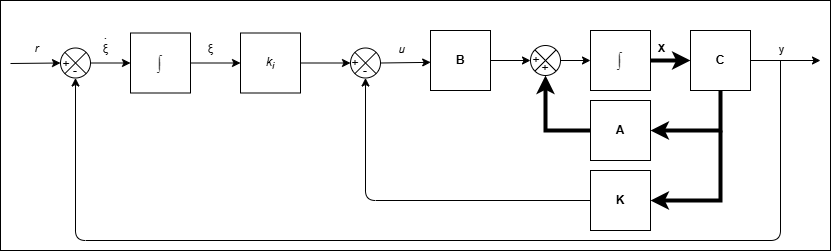

In [13]:
display_image_with_caption("figs/diagrama_de_blocos_se.png", 6, "Diagrama de blocos do controlador por realimentação de estados com integrador.")


Conforme verificado na seção anterior, Equação 13, o sistema em malha aberta é controlável. Consequentemente, é possível alocar os polos de malha fechada arbitrariamente para satisfazer os requisitos de desempenho desejados. 

Para cálculo do controlador, considera-se apenas a coluna da matriz $\mathbf{B}$ referente a tensão, visto que esta é a variável manipulada. O torque de carga, neste cenário, é tratado como um distúrbio e não compõe o vetor de atuação. 

Os polos de malha aberta do sistema situam-se em $0,994 \pm 0,004j$. Para o projeto, optou-se por alocar os polos de malha fechada de modo a obter uma resposta mais rápida, porém conservadora o suficiente para evitar a saturação do sinal de controle. Assim, definiram-se os polos desejados em $0,5 \pm 0,5j$ e o polo real adicional, associado à dinâmica do integrador, em $0,6$. Por fim, aplicando a fórmula de Ackermann para o sistema aumentado, obtêm-se os ganhos:

Ganhos K (Estados): [360.31       260.98024535]
Ganho Ki (Integrador): -58.58647137842874



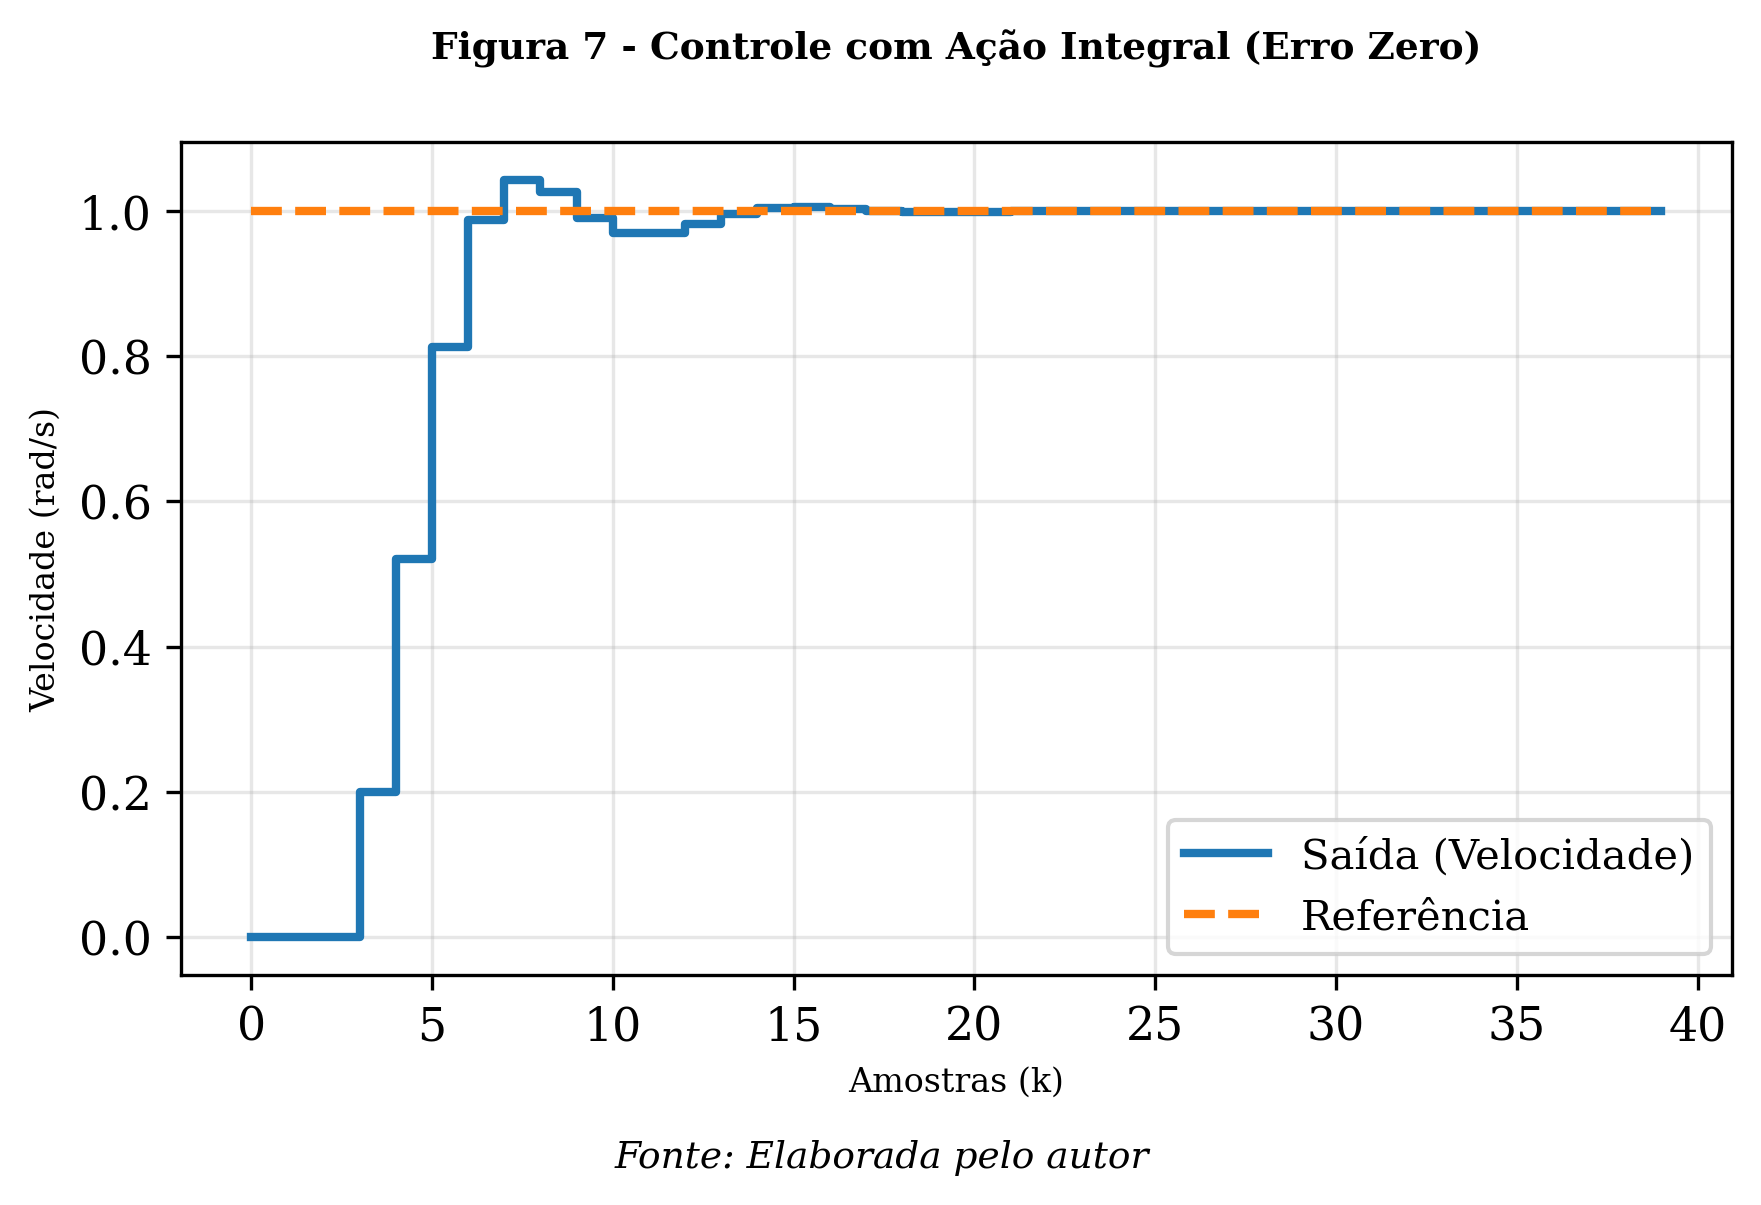

In [14]:
# A_aum = [ A   0 ]
#         [ -C  1 ]
zeros_col = np.zeros((2, 1))
linha_integrador = np.hstack((-Cd, [[1]]))                          # [0, -1, 1]
A_aum = np.vstack((np.hstack((Ad, zeros_col)), linha_integrador))   # Adiciona a coluna de zeros

Bd_controle = Bd[:, 0].reshape(-1, 1)                               
B_aum = np.vstack((Bd_controle, [[0]]))                             # Bd apenas com a tensão

polos_desejados = np.array([0.5 + 0.5j, 0.5 - 0.5j, 0.6])           # Polos da realimentação e do integrador

K_aum = ct.place(A_aum, B_aum, polos_desejados)

print(f"Ganhos K (Estados): {K_aum[0, :2]}")
print(f"Ganho Ki (Integrador): {K_aum[0, 2]}")

B_ref = np.array([[0], [0], [1]])
A_fechada = A_aum - B_aum @ K_aum
C_aum = np.array([[0, 1, 0]])
sys_ci = ct.StateSpace(A_fechada, B_ref, C_aum, 0, dt=1)

t = np.arange(0, 40, 1)
U = np.ones_like(t)                                                 # Degrau de referência 1 rad/s
t_out, y_out = ct.forced_response(sys_ci, T=t, U=U)

print_graph(
    t=t_out, 
    y=y_out.flatten(), 
    title="Controle com Ação Integral (Erro Zero)", 
    xlabel="Amostras (k)", 
    ylabel="Velocidade (rad/s)",
    fig_number=7,
    t2=t_out,
    y2=U,
    label1="Saída (Velocidade)",
    label2="Referência",
    use_step=True  
)



A Figura 7 apresenta a resposta do sistema em malha fechada a um degrau unitário de referência de velocidade. Observa-se que a estratégia de controle por realimentação de estados com ação integral cumpriu os requisitos do projeto. 

No que tange ao regime transitório, o sistema apresentou um tempo de subida de aproximadamente 6 amostras e um sobressinal percentual reduzido. A dinâmica oscilatória foi rapidamente amortecida, resultando em um tempo de acomodação curto, estabilizando-se por volta da 15ª amostra.

Em relação ao regime permanente, constata-se a eficácia do integrador inserido na malha de controle. O erro de rastreamento convergiu para zero, garantindo que a velocidade de saída se igualasse à referência solicitada, eliminando o erro estático inerente a realimentação puramente proporcional.  

## 6. Observador de estados
Para a implementação da lei de controle por realimentação de estados, é necessário que o vetor de estados completo esteja disponível. Quando nem todas as variáveis de estado são mensuráveis diretamente, ou quando se deseja reduzir o ruído medição, utiliza-se um observador de estados para gerar uma estimativa $\mathbf{\hat{x}}$

O projeto do observador baseia-se no princípio de alocar os autovalores da matriz de erro e estimação, Equação 16. Um critério fundamental de projeto é garantir que a dinâmica do observador seja significativamente mais rápida que a dinâmica do controlador em malha fechada.

$$
(\mathbf{A} - \mathbf{L}\mathbf{C}) \tag{16}
$$

Recordando que os polos do controlador foram alocados em $0,5 \pm 0,5j$, optou-se por alocar os polos do observador mais próximos da origem do plano Z, em $0,2 \pm 0,2j$ resultando em uma dinâmica mais acelerada. Aplicando a fórmula de Ackermann para o cálculo do vetor de ganhos $\mathbf{L}$:


Matriz de ganho do observador L: 
[[0.75230941]
 [1.58580769]]



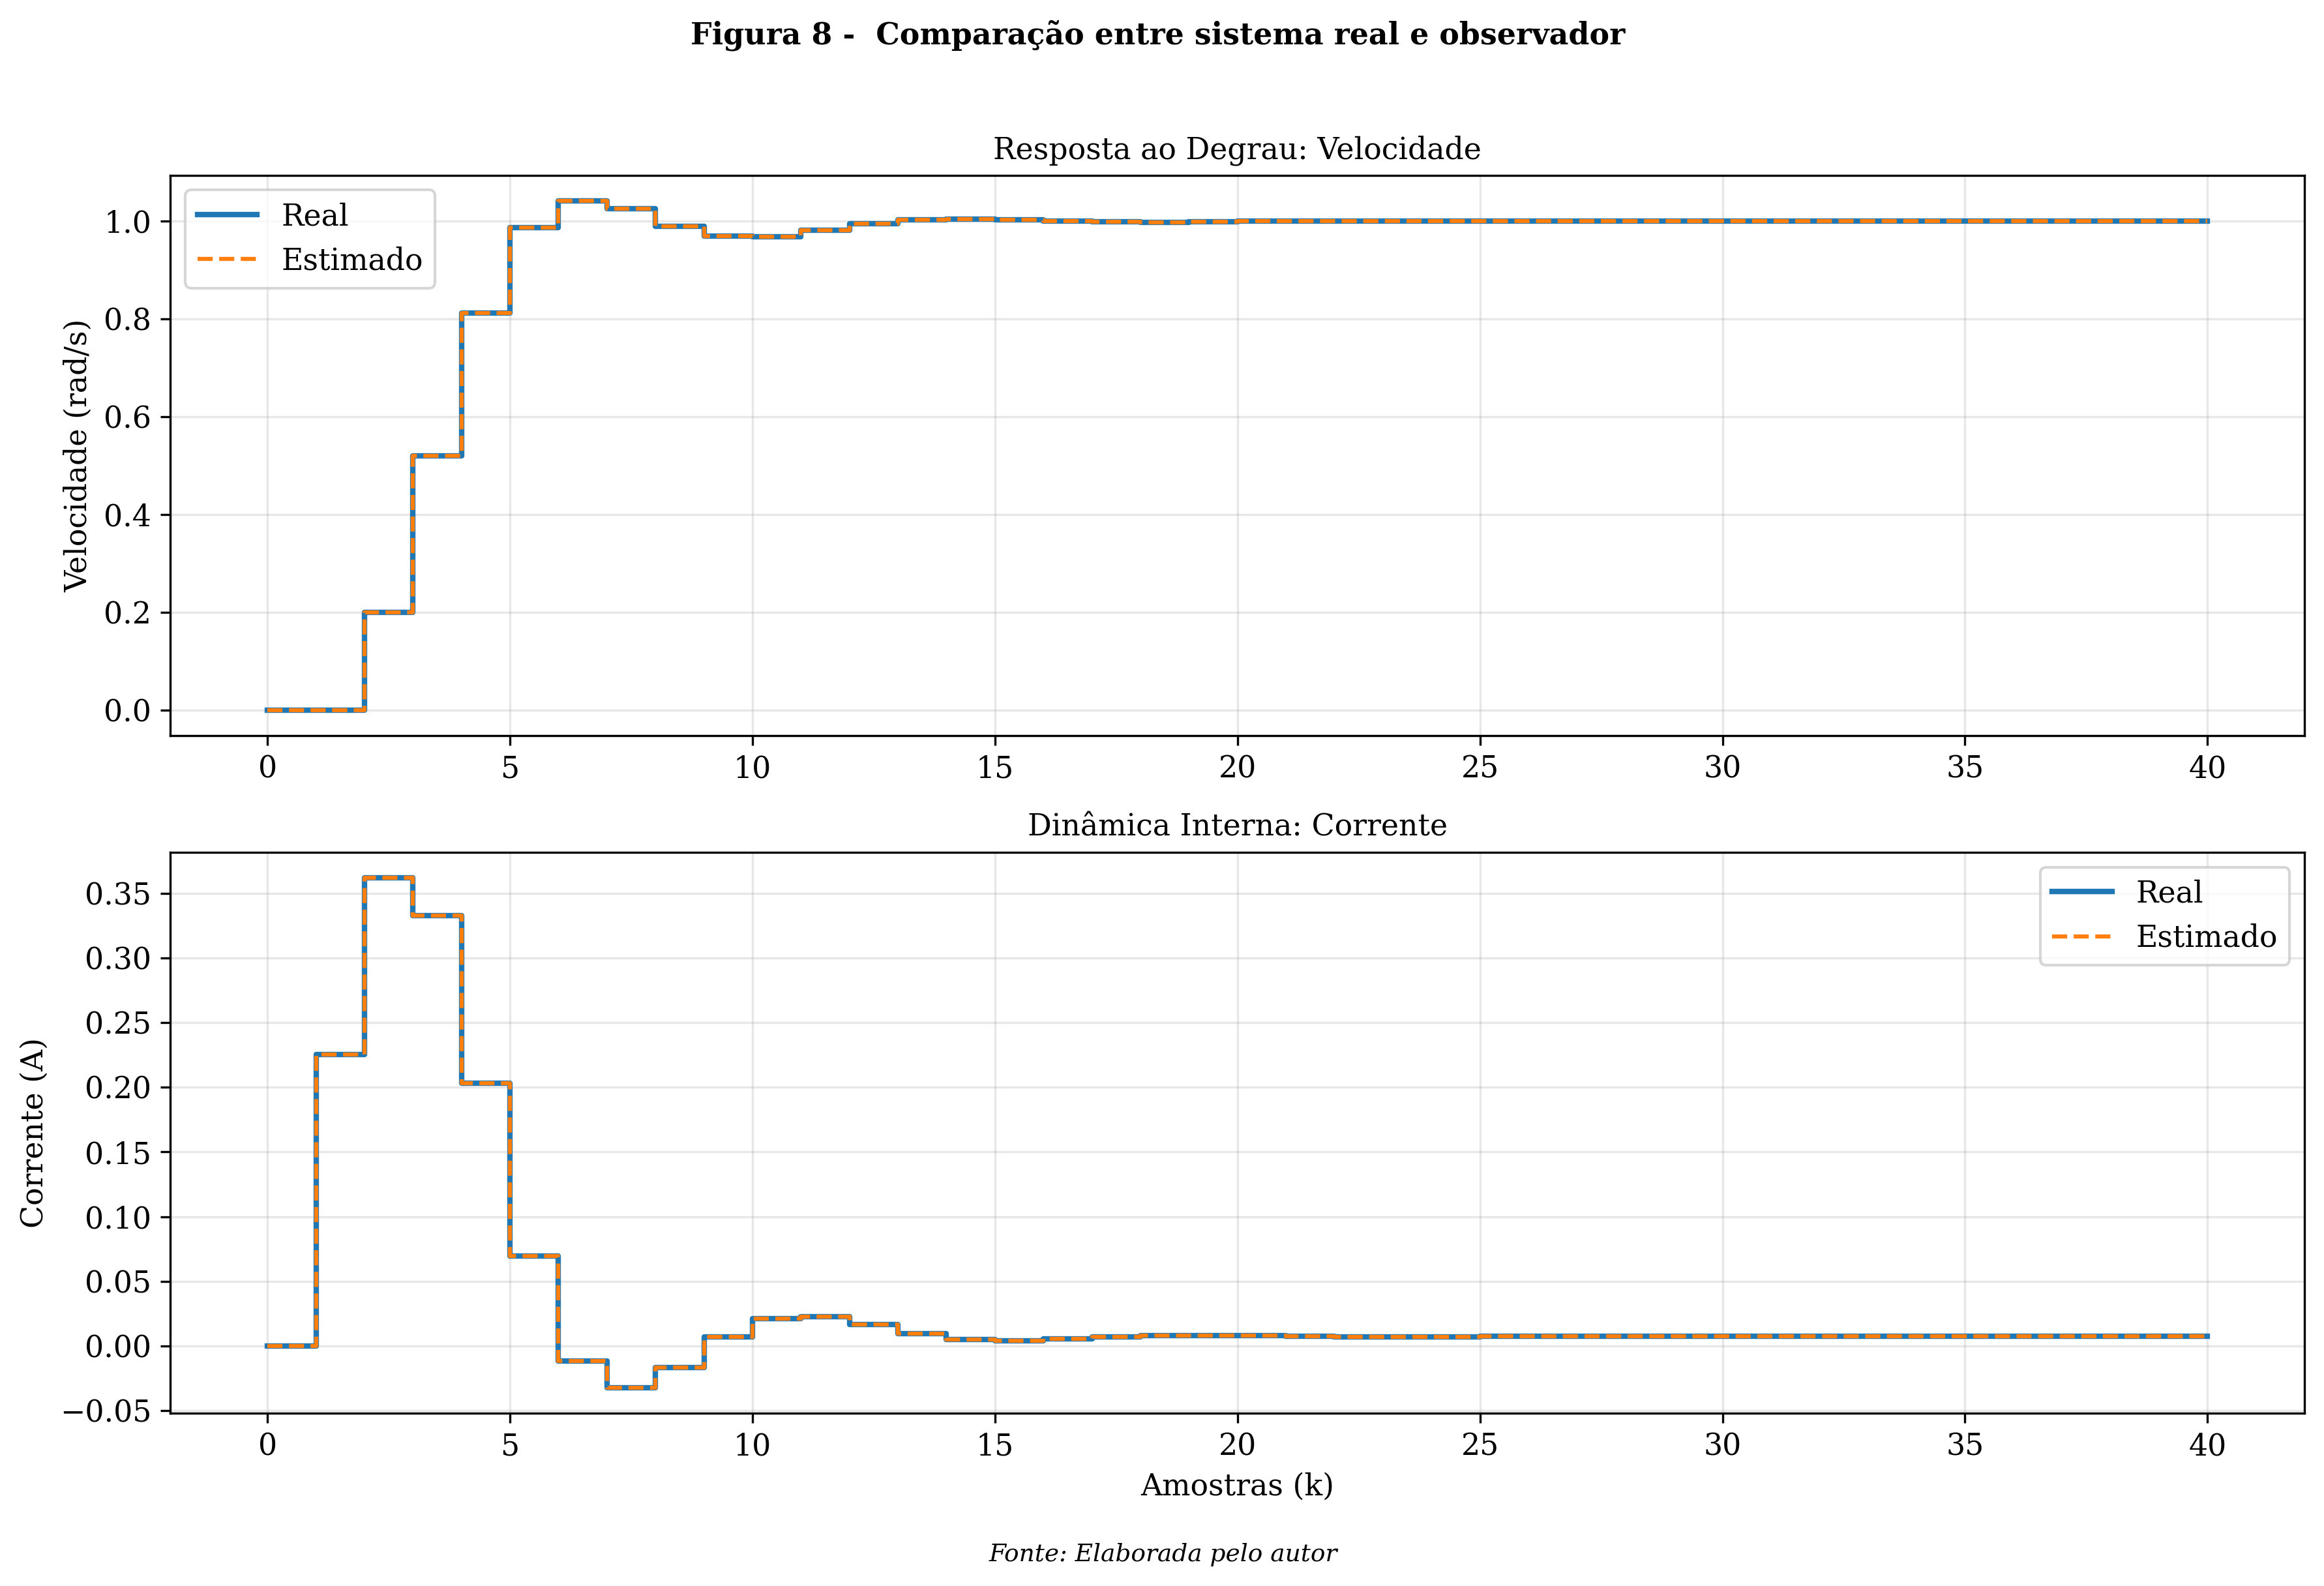

In [ ]:
polos_observador = np.array([0.2 + 0.2j, 0.2 - 0.2j])
K_x = K_aum[:, :2]                                      # Ganhos da planta
K_i = K_aum[:, 2:]                                      # Ganho do integrador
L = ct.place(Ad.T, Cd.T, polos_observador).T            # Cálculo do ganho L
print(f"Matriz de ganho do observador L: \n{L}")

row1 = np.hstack((                                      # Planta
    Ad, 
    -Bd_controle @ K_i, 
    -Bd_controle @ K_x))                                

row2 = np.hstack((                                      # Integrador
    -Cd, 
    [[1]], 
    np.zeros((1, 2))))                


row3 = np.hstack((                                      # Observador
    L @ Cd, 
    -Bd_controle @ K_i, 
    Ad - Bd_controle @ K_x - L @ Cd))

A_big = np.vstack((row1, row2, row3))                   # Matriz completa

# Matriz B 
# A entrada é apenas a Referência (r)
# Planta: 0, Integrador: 1, Observador: 0
B_big = np.array([[0], [0], [1], [0], [0]])

# Matriz C
# [Velocidade Real, Velocidade Estimada, Corrente Real, Corrente Estimada]
# x = [ia, w, xi, ia_est, w_est]
C_big = np.array([
    [0, 1, 0, 0, 0], # y1: Velocidade Real
    [0, 0, 0, 0, 1], # y2: Velocidade Estimada
    [1, 0, 0, 0, 0], # y3: Corrente Real
    [0, 0, 0, 1, 0]  # y4: Corrente Estimada
])
D_big = np.zeros((4, 1))

# Simulação
sys_completo = ct.StateSpace(A_big, B_big, C_big, D_big, dt=1)
t, y = ct.step_response(sys_completo, T=40)
y = np.squeeze(y)

print_graph_subplots(
    t=t,
    y_data=[(y[0], y[1]), (y[2], y[3])],
    titles=['Resposta ao Degrau: Velocidade', 
            'Dinâmica Interna: Corrente'],
    ylabels=['Velocidade (rad/s)', 'Corrente (A)'],
    xlabel='Amostras (k)',
    fig_number=8,
    fig_title=' Comparação entre sistema real e observador '
)


A Figura 8 apresenta a validação do observador através de uma simulação comparativas entre os estados reais do sistema, linha contínua azul, e os estados estimados, linha tracejada laranja. 

No gráfico superior, referente à velocidade (saída), e no gráfico inferior, referente à corrente (estado interno), observa-se que as curvas estimadas se sobrepõem quase perfeitamente às curvas reais desde as primeiras amostras. A convergência instantânea visualizada corrobora a escolha adequada dos polos, demonstrando que o observador é capaz de reconstruir fielmente a dinâmica interna do sistema.   

### Apêndice A - Dependências necessárias e funções auxiliares

In [24]:
# dependências necessárias
import control as ct 
import matplotlib.pyplot as plt 
import numpy as np 
from IPython.display import Image, HTML, display
import io, base64
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# Configuração global de fontes do matplotlib
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Times New Roman', 'Computer Modern Roman']
plt.rcParams['mathtext.fontset'] = 'cm'  # Computer Modern para fórmulas matemáticas
plt.rcParams['font.size'] = 11

# funções auxiliares 
def print_graph(t, y, title, xlabel, ylabel, fig_number=1, source="Elaborada pelo autor", t2=None, y2=None, label1="Contínuo", label2="Discreto", use_step=False):
    plt.figure(figsize=(6, 4))
    
    # Plotar primeira curva
    if use_step:
        plt.step(t, y, where='post', linewidth=2, label=label1)
    else:
        plt.plot(t, y, linewidth=2, label=label1)
    
    # Se houver segunda curva, plotá-la
    if t2 is not None and y2 is not None:
        if use_step:
            plt.step(t2, y2, where='post', linestyle='--', linewidth=2, label=label2)
        else:
            step_plot = 50  # Plotar a cada 50 pontos para visualização mais clara
            plt.step(t2[::step_plot], y2[::step_plot], label=label2, where='post', 
                    linestyle='--')
    
    plt.title(f"Figura {fig_number} - {title}", fontsize=9, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # Adicionar legenda se houver duas curvas
    if t2 is not None and y2 is not None:
        plt.legend(fontsize=10)
    
    fig = plt.gcf()
    fig.text(0.5, 0.01, f"Fonte: {source}", fontsize=9, style='italic', ha='center')
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=300, bbox_inches='tight')
    buf.seek(0)
    img_b64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    plt.close(fig)
    display(HTML(f'<div style="text-align:center"><img src="data:image/png;base64,{img_b64}" /></div>'))

def print_pzmap(system, fig_number, source="Elaborado pelo autor"):
    fig = plt.figure(figsize=(8, 6))
    poles = ct.poles(system)
    zeros = ct.zeros(system)
    is_discrete = system.dt is not None and system.dt > 0   

    # Lista para armazenar as labels dos polos e zeros
    legend_labels = []
    
    if is_discrete:
        circle = plt.Circle((0, 0), 1, color='gray', fill=False, 
                           linestyle='--', linewidth=1.5)
        plt.gca().add_patch(circle)
        legend_labels.append(('Círculo Unitário', None))

    # Plotar polos sem anotações individuais
    for i, p in enumerate(poles):
        plt.plot(np.real(p), np.imag(p), 'x', markersize=12, color='blue', 
                 markeredgewidth=2)
        
        # Adicionar à lista de legendas
        if np.imag(p) >= 0:
            pole_label = f'{np.real(p):.3f} + {np.imag(p):.3f}j' if np.imag(p) != 0 else f'{np.real(p):.3f}'
        else:
            pole_label = f'{np.real(p):.3f} - {abs(np.imag(p)):.3f}j'
        legend_labels.append((f'Polo: {pole_label}', 'blue'))
    
    # Plotar zeros sem anotações individuais
    if len(zeros) > 0:
        for i, z in enumerate(zeros):
            plt.plot(np.real(z), np.imag(z), 'o', markersize=10, color='red', 
                     markerfacecolor='none', markeredgewidth=2)
            
            # Adicionar à lista de legendas
            if np.imag(z) >= 0:
                zero_label = f'{np.real(z):.3f} + {np.imag(z):.3f}j' if np.imag(z) != 0 else f'{np.real(z):.3f}'
            else:
                zero_label = f'{np.real(z):.3f} - {abs(np.imag(z)):.3f}j'
            legend_labels.append((f'Zero: {zero_label}', 'red'))
    
    plt.grid(True, alpha=0.3)
    
    if is_discrete:
        plt.xlabel('Parte Real', fontsize=11)
        plt.ylabel('Parte Imaginária', fontsize=11)
        plt.title(f'Figura {fig_number} - Mapa de Polos e Zeros (Sistema Discreto)', 
                 fontsize=10, fontweight='bold', pad=20)
    else:
        plt.xlabel('Eixo Real', fontsize=11)
        plt.ylabel('Eixo Imaginário', fontsize=11)
        plt.title(f'Figura {fig_number} - Mapa de Polos e Zeros', 
                 fontsize=9, fontweight='bold', pad=20)
    
    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)
    plt.axis('equal')
    
    # Criar elementos de legenda customizados
    from matplotlib.lines import Line2D
    custom_lines = []
    custom_labels = []
    
    for label, color in legend_labels:
        if color == 'blue':
            custom_lines.append(Line2D([0], [0], marker='x', color='w', markerfacecolor='blue', 
                                      markeredgecolor='blue', markersize=10, markeredgewidth=2))
        elif color == 'red':
            custom_lines.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
                                      markeredgecolor='red', markersize=10, markeredgewidth=2))
        else:
            custom_lines.append(Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5))
        custom_labels.append(label)
    
    # Posicionar legenda dentro do gráfico
    plt.legend(custom_lines, custom_labels, loc='upper right', fontsize=9, framealpha=0.9)
    
    fig.text(0.5, 0.01, f'Fonte: {source}', fontsize=9, style='italic', ha='center')
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=300, bbox_inches='tight')
    buf.seek(0)
    img_b64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    plt.close(fig)
    
    display(HTML(f'<div style="text-align:center"><img src="data:image/png;base64,{img_b64}" /></div>'))



def display_image_with_caption(image_path, figure_number, caption_text, width="80%"):
    try:
        with open(image_path, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
        
        html_code = f'''
        <div style="text-align: center; margin: 20px 0;">
            <p style="font-size: 11px; font-weight: bold; margin-bottom: 15px; margin-top: 20px; text-align: center; font-family: serif;">
                Figura {figure_number} - {caption_text}
            </p>
            <img src="data:image/png;base64,{encoded_string}" 
                 alt="Figura {figure_number}" 
                 width="{width}" 
                 style="border: 1px solid #ddd; padding: 5px; display: block; margin: 0 auto;">
            <p style="font-size: 9px; font-style: italic; margin-top: 10px; text-align: center; font-family: serif;">
                Fonte: Elaborada pelo autor
            </p>
        </div>
        '''
        
        display(HTML(html_code))
        
    except FileNotFoundError:
        print(f"Erro: Arquivo '{image_path}' não encontrado.")
    except Exception as e:
        print(f"Erro ao carregar imagem: {str(e)}")

def print_graph_subplots(t, y_data, titles, ylabels, xlabel, fig_number,  fig_title, source="Elaborada pelo autor"):
    """
    Gera gráfico com subplots empilhados
    
    Args:
        t: vetor de tempo
        y_data: lista de tuplas [(real1, estimado1), (real2, estimado2), ...]
        titles: lista de títulos para cada subplot
        ylabels: lista de labels do eixo y
        xlabel: label do eixo x
        fig_number: número da figura
    """
    n_plots = len(y_data)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 4*n_plots))
    
    if n_plots == 1:
        axes = [axes]
    
    for i, (ax, (y_real, y_est), title, ylabel) in enumerate(zip(axes, y_data, titles, ylabels)):
        ax.step(t, y_real, label='Real', linewidth=2)
        ax.step(t, y_est, '--', label='Estimado')
        ax.set_title(title, fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        if i == n_plots - 1:
            ax.set_xlabel(xlabel, fontsize=11)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    fig.suptitle(f'Figura {fig_number} - {fig_title}', fontsize=11, fontweight='bold', y=0.995)
    fig.text(0.5, 0.01, f'Fonte: {source}', fontsize=9, style='italic', ha='center')
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=300, bbox_inches='tight')
    buf.seek(0)
    img_b64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    plt.close(fig)
    display(HTML(f'<div style="text-align:center"><img src="data:image/png;base64,{img_b64}" /></div>'))

<style>
    /* 1. Força o tamanho do papel para A4 */
    @page {
    size: A4 portrait;
    margin-top: 3cm;
    margin-bottom: 2cm;
    margin-left: 3cm;
    margin-right: 2cm;
    }

    /* 2. Ajusta o corpo do relatório para usar a largura total */
    div.jp-Notebook {
        width: 100% !important;
        max-width: 100% !important;
        margin: 0 !important;
        padding: 0 !important;
    }

    /* 3. Aumenta um pouco a fonte base se estiver muito pequena */
    body {
        font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
        font-size: 14px; /* O padrão costuma ser 11px ou 12px, 14px fica melhor para leitura */
    }
    
    /* 4. Garante que as tabelas e imagens não estourem a margem */
    img, table {
        max-width: 100%;
    }
</style>